# Automated Deep Ensemble with Uncertainty Quantification

In [1]:
import nest_asyncio
nest_asyncio.apply()

In [2]:
import tensorflow_probability as tfp
tfd = tfp.distributions

In [3]:
import json
import os
import pathlib
import shutil

!export TF_CPP_MIN_LOG_LEVEL=3
!export TF_XLA_FLAGS=--tf_xla_enable_xla_devices

import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tqdm import tqdm

In [4]:
available_gpus = tf.config.list_physical_devices("GPU")
n_gpus = len(available_gpus)
if n_gpus > 1:
    n_gpus -= 1
is_gpu_available = n_gpus > 0

if is_gpu_available:
    print(f"{n_gpus} GPU{'s are' if n_gpus > 1 else ' is'} available.")
else:
    print("No GPU available")

7 GPUs are available.


In [5]:
def load_data(fileIn):
    allFiles = np.loadtxt(fileIn)
    print('total files:' + str(allFiles.shape))
    
    X = allFiles[:, :6].astype('float32')
    y = allFiles[:, 6:].astype('float32')
    
    print(X.shape, y.shape)
    print('MIN: ', X.min(axis=0), y.min(axis=0))
    print('MAX: ', X.max(axis=0), y.max(axis=0))
    
    return X, y

In [6]:
X, y = load_data('data/prop_spec_only.txt')

total files:(1002, 13)
(1002, 6) (1002, 7)
MIN:  [3.7349e-05 6.5130e-02 9.7873e+00 1.2786e+03 5.6994e+02 5.0339e-06] [1.000e-04 0.000e+00 0.000e+00 0.000e+00 1.000e-04 7.027e-01 0.000e+00]
MAX:  [3.7423e-05 6.9571e-02 1.0126e+01 1.2949e+03 5.8160e+02 5.4892e-06] [0.1838 0.09   0.03   0.05   0.1906 0.9405 0.1858]


In [7]:
from sklearn.model_selection import train_test_split
train_X, test_X, train_y, test_y = train_test_split(X, y[:,:], test_size=0.25, random_state=42)

In [8]:
valid_X = test_X
valid_y = test_y

In [9]:
print(f'train_X shape: {np.shape(train_X)}')
print(f'train_y shape: {np.shape(train_y)}')
print(f'valid_X shape: {np.shape(valid_X)}')
print(f'valid_y shape: {np.shape(valid_y)}')
print(f'test_X shape: {np.shape(test_X)}')
print(f'test_y shape: {np.shape(test_y)}')

train_X shape: (751, 6)
train_y shape: (751, 7)
valid_X shape: (251, 6)
valid_y shape: (251, 7)
test_X shape: (251, 6)
test_y shape: (251, 7)


In [10]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

In [11]:
# preprocessor_input = Pipeline([('stdscaler', StandardScaler()), ('minmax', MinMaxScaler(feature_range=(0, 1)))])
# preprocessor_input.fit(train_X)
# preprocessor_output = Pipeline([('stdscaler', StandardScaler()), ('minmax', MinMaxScaler(feature_range=(0, 1)))])
# preprocessor_output.fit(train_y)


preprocessor_input = Pipeline([('minmax', MinMaxScaler(feature_range=(0, 1)))])
preprocessor_input.fit(train_X)
preprocessor_output = Pipeline([('minmax', MinMaxScaler(feature_range=(0, 1)))])
preprocessor_output.fit(train_y)


X_train = preprocessor_input.transform(train_X)
Y_train = preprocessor_output.transform(train_y)
X_val = preprocessor_input.transform(valid_X)
Y_val = preprocessor_output.transform(valid_y)
X_test = preprocessor_input.transform(test_X)
Y_test = preprocessor_output.transform(test_y)
print(X_train.shape)
print(Y_train.shape)

(751, 6)
(751, 7)


In [12]:
print(X_train.shape)
print(Y_train.shape)

(751, 6)
(751, 7)


In [13]:
train_invalid_indices = np.isnan(X_train).any(axis=1)
val_invalid_indices = np.isnan(X_val).any(axis=1)
test_invalid_indices = np.isnan(X_test).any(axis=1)

In [14]:
X_train = X_train[~train_invalid_indices]
Y_train = Y_train[~train_invalid_indices]
X_val = X_val[~val_invalid_indices]
Y_val = Y_val[~val_invalid_indices]
X_test = X_test[~test_invalid_indices]
Y_test = Y_test[~test_invalid_indices]

In [15]:
import ray

if not(ray.is_initialized()):
    if is_gpu_available:
        ray.init(num_cpus=n_gpus, num_gpus=n_gpus, log_to_driver=False)            
    else:
        ray.init(num_cpus=2, log_to_driver=False)
        

2022-09-09 03:03:33,488	INFO services.py:1412 -- View the Ray dashboard at http://127.0.0.1:8265


In [16]:
print(X_train.shape)
print(Y_train.shape)

(751, 6)
(751, 7)


In [17]:
def load_data_test(random_state=42):
    return (X_test, Y_test)

In [18]:
import random
train_idx = random.sample(range(X_train.shape[0]),X_train.shape[0])
val_idx = random.sample(range(X_val.shape[0]),X_val.shape[0])

In [19]:
from sklearn.model_selection import train_test_split

def load_data_train_valid(verbose=0, random_state=42):
    
    #X_train = ray.get(X_train_id)
    #Y_train = ray.get(Y_train_id)
    #X_val = ray.get(X_val_id)
    #Y_val = ray.get(Y_val_id)
    #X_test = ray.get(X_test_id)
    #Y_test = ray.get(Y_test_id)
    
    train_X, valid_X, train_y, valid_y = X_train[train_idx],  X_val[val_idx], Y_train[train_idx], Y_val[val_idx]

    if verbose:
        print(f'train_X shape: {np.shape(train_X)}')
        print(f'train_y shape: {np.shape(train_y)}')
        print(f'valid_X shape: {np.shape(valid_X)}')
        print(f'valid_y shape: {np.shape(valid_y)}')
    return (train_X, train_y), (valid_X, valid_y)



## Define the Neural Architecture Search Space <a class="anchor" id="define-the-neural-architecture-search-space"></a>

The neural architecture search space is composed of discrete decision variables. For each decision variable we choose among a list of possible operation to perform (e.g., fully connected, ReLU). To define this search space, it is necessary to use two classes:

* `KSearchSpace` (for Keras Search Space): represents a directed acyclic graph (DAG) in which each node represents a chosen operation. It represents the possible neural networks that can be created.
* `SpaceFactory`: is a utilitiy class used to pack the logic of a search space definition and share it with others.

Then, inside a `KSearchSpace` we will have two types of nodes:
* `VariableNode`: corresponds to discrete decision variables and are used to define a list of possible operation.
* `ConstantNode`: corresponds to fixed operation in the search space (e.g., input/outputs)

Finally, it is possible to reuse any `tf.keras.layers` to define a `KSearchSpace`. However, it is important to wrap each layer in an `operation` to perform a lazy memory allocation of tensors.

In [20]:

import collections

from deephyper.nas import KSearchSpace

# # Decision variables are represented by nodes in a graph
from deephyper.nas.node import ConstantNode, VariableNode

# # The "operation" creates a wrapper around Keras layers avoid allocating 
# # memory each time a new layer is defined in the search space
# # For Skip/Residual connections we use "Zero", "Connect" and "AddByProjecting"
from deephyper.nas.operation import operation, Zero, Connect, AddByProjecting, Identity

Dense = operation(tf.keras.layers.Dense)

# Possible activation functions
ACTIVATIONS = [
    tf.keras.activations.elu,
    #tf.keras.activations.gelu,
    tf.keras.activations.hard_sigmoid,
    tf.keras.activations.linear,
    tf.keras.activations.relu,
    tf.keras.activations.selu,
    tf.keras.activations.sigmoid,
    tf.keras.activations.softplus,
    tf.keras.activations.softsign,
    tf.keras.activations.swish,
    tf.keras.activations.tanh,
]

## Define the Evaluator Object

The `Evaluator` object is responsible of defining the backend used to distribute the function evaluation in DeepHyper.

In [21]:
from deephyper.evaluator import Evaluator
from deephyper.evaluator.callback import LoggerCallback
from deephyper.problem import NaProblem


def get_evaluator(run_function):
    
    # Default arguments for Ray: 1 worker and 1 worker per evaluation
    method_kwargs = {
        "num_cpus": 1, 
        "num_cpus_per_task": 1,
        "callbacks": [LoggerCallback()] # To interactively follow the finished evaluations,
    }

    # If GPU devices are detected then it will create 'n_gpus' workers
    # and use 1 worker for each evaluation
    if is_gpu_available:
        method_kwargs["num_cpus"] = n_gpus
        method_kwargs["num_gpus"] = n_gpus
        method_kwargs["num_cpus_per_task"] = 1
        method_kwargs["num_gpus_per_task"] = 1

    evaluator = Evaluator.create(
        run_function, 
        method="ray", 
        method_kwargs=method_kwargs
    )
    print(f"Created new evaluator with {evaluator.num_workers} worker{'s' if evaluator.num_workers > 1 else ''} and config: {method_kwargs}", )
    
    return evaluator

For neural architecture search a standard training pipeline is provided by the `run_base_trainer` function from the `deephyper.nas.run` module.

In [22]:
from deephyper.nas.run import run_base_trainer

In [23]:
results = {} # used to store the results of different search algorithms
max_evals = 400 # maximum number of iteratins for all searches

In [24]:
from deephyper.search.nas import RegularizedEvolution

In [25]:
import tensorflow_probability as tfp
# tfd = tfp.distributions

Then, instead of minimising the mean squared error we will minimize the negative log-likelihood baed on the learned probability distribution $p(y|\mathbf{x};\theta)$ where $\theta$ represents a neural network (architecture, training hyperparameters, weights).

In [26]:
def nll(y, rv_y):
    """Negative log likelihood for Tensorflow probability.
    
    Args:
        y: true data.
        rv_y: learned (predicted) probability distribution.
    """
    return -rv_y.log_prob(y)

Let us visualize the learned uncertainty estimates.

The learned mean estimates appears to be worse than when minimizing the mean squared error loss. Also, we can see than the variance estimate are not meaningful in areas missing data (white background) and do not learn properly the noise in are with data (grey background).

## AutoDEUQ: Automated Deep Ensemble with Uncertainty Quantification

AutoDEUQ is an algorithm in 2 steps:
1. joint hyperparameter and neural architecture search to generate a catalog of models.
2. build an ensemble from the catalog

To this end we start by editing slightly the previous `RegressionFactory` by adding the `DistributionLambda` layer as output.

In [27]:
DistributionLambda = operation(tfp.layers.DistributionLambda)

In [28]:
class RegressionUQSpace(KSearchSpace):
    
    def __init__(self, input_shape, output_shape, seed=None, num_layers=3):
        super().__init__(input_shape, output_shape, seed=seed)
        
        self.num_layers = 3
    
    def build(self):

        out_sub_graph = self.build_sub_graph(self.input_nodes[0], self.num_layers)
        
        output_dim = self.output_shape[0]
        output_dense = ConstantNode(op=Dense(output_dim*2))  
        self.connect(out_sub_graph, output_dense)
        
        
        output_dist = ConstantNode(
            op=DistributionLambda(
                lambda t: tfd.Normal(
                    loc=t[..., :output_dim],
                    scale=1e-3 + tf.math.softplus(0.05 * t[..., output_dim:]),
                )
            )
        )
        self.connect(output_dense, output_dist)

        return self

    def build_sub_graph(self, input_node, num_layers=3):
        

        # Look over skip connections within a range of the 3 previous nodes
        anchor_points = collections.deque([input_node], maxlen=3)
        
        prev_node = input_node
        
        for _ in range(num_layers):
            
            # Create a variable node to list possible "Dense" layers
            dense = VariableNode()
            
            # Add the possible operations to the dense node
            self.add_dense_to_(dense)
            
            # Connect the previous node to the dense node
            self.connect(prev_node, dense)

            # Create a constant node to merge all input connections
            merge = ConstantNode()
            merge.set_op(
                AddByProjecting(self, [dense], activation="relu")
            )

            for node in anchor_points:
                
                # Create a variable node for each possible connection
                skipco = VariableNode()
                
                skipco.add_op(Zero()) # corresponds to no connection
                skipco.add_op(Connect(self, node)) # corresponds to (node => skipco)
                
                # Connect the (skipco => merge)
                self.connect(skipco, merge)

 
            # ! for next iter
            prev_node = merge
            anchor_points.append(prev_node)

        return prev_node

    def add_dense_to_(self, node):
        
        # We add the "Identity" operation to allow the choice "doing nothing"
        node.add_op(Identity())
        
        step = 16
        for units in range(step, step * 16 + 1, step):
            for activation in ACTIVATIONS:
                node.add_op(Dense(units=units, activation=activation))

For joint hyperparameter and neural architecture search it is possible to use the `problem.add_hyperparameter(...)` to define variable hyperparameters in the NAS Problem.

In [29]:
problem_uq = NaProblem()

problem_uq.load_data(load_data_train_valid)

#problem_uq.preprocessing(stdscaler)

problem_uq.search_space(RegressionUQSpace, num_layers=3)

problem_uq.hyperparameters(
    batch_size=problem_uq.add_hyperparameter((10,100), "batch_size"),
    learning_rate=problem_uq.add_hyperparameter(
        (1e-4, 0.1, "log-uniform"),
        "learning_rate",
    ),
    optimizer=problem_uq.add_hyperparameter(
        ["sgd", "rmsprop", "adagrad", "adam", "adadelta", "adamax", "nadam"],
        "optimizer",
    ),
    patience_ReduceLROnPlateau=problem_uq.add_hyperparameter(
        (10, 20), "patience_ReduceLROnPlateau"
    ),
    patience_EarlyStopping=problem_uq.add_hyperparameter(
        (20, 30), "patience_EarlyStopping"
    ),
    num_epochs=500,
    callbacks=dict(
        ReduceLROnPlateau=dict(monitor="val_loss", mode="min", verbose=0, patience=5),
        EarlyStopping=dict(monitor="val_loss", mode="min", verbose=0, patience=10),
        # We save trained models in neural architecture search
        ModelCheckpoint=dict(
            monitor="val_loss",
            mode="min",
            save_best_only=True,
            verbose=0,
            filepath="model.h5",
            save_weights_only=False,
        ),
    ),
)

problem_uq.loss(nll)

problem_uq.metrics([])

# The objective is maximized so we take the negative of the validation loss
# where the loss is minimized
problem_uq.objective("-val_loss")

problem_uq

Problem is:
    - search space   : __main__.RegressionUQSpace
    - data loading   : __main__.load_data_train_valid
    - preprocessing  : None
    - hyperparameters: 
        * verbose: 0
        * batch_size: batch_size, Type: UniformInteger, Range: [10, 100], Default: 55
        * learning_rate: learning_rate, Type: UniformFloat, Range: [0.0001, 0.1], Default: 0.0031622777, on log-scale
        * optimizer: optimizer, Type: Categorical, Choices: {sgd, rmsprop, adagrad, adam, adadelta, adamax, nadam}, Default: sgd
        * patience_ReduceLROnPlateau: patience_ReduceLROnPlateau, Type: UniformInteger, Range: [10, 20], Default: 15
        * patience_EarlyStopping: patience_EarlyStopping, Type: UniformInteger, Range: [20, 30], Default: 25
        * num_epochs: 500
        * callbacks: {'ReduceLROnPlateau': {'monitor': 'val_loss', 'mode': 'min', 'verbose': 0, 'patience': 5}, 'EarlyStopping': {'monitor': 'val_loss', 'mode': 'min', 'verbose': 0, 'patience': 10}, 'ModelCheckpoint': {'monito

In [30]:
results_uq = {}

The `max_evals` has to be superior or equal to 400 to start having a good UQ estimate.

In [31]:
from deephyper.search.nas import AgEBO


if os.path.exists("agebo_search"):
    shutil.rmtree("agebo_search")

# "n_jobs" is the number of processes used to refresh the state of the surrogate model used in AgEBO 
agebo_search = AgEBO(problem_uq, get_evaluator(run_base_trainer), log_dir="agebo_search", n_jobs=7)

results_uq["agebo"] = agebo_search.search(max_evals=max_evals)

/lcrc/project/cosmo_ai/nramachandra/Projects/PRISM/deephyper_repo/deephyper/evaluator/_evaluator.py:101: UserWarning: Applying nest-asyncio patch for IPython Shell!
  warnings.warn(


Created new evaluator with 7 workers and config: {'num_cpus': 7, 'num_cpus_per_task': 1, 'callbacks': [<deephyper.evaluator.callback.LoggerCallback object at 0x1509829a3460>], 'num_gpus': 7, 'num_gpus_per_task': 1}
[00001] -- best objective: 0.59118 -- received objective: 0.59118
[00002] -- best objective: 0.63166 -- received objective: 0.63166
[00003] -- best objective: 0.63166 -- received objective: 0.58774
[00004] -- best objective: 0.63166 -- received objective: 0.44691
[00005] -- best objective: 0.63166 -- received objective: 0.56221
[00006] -- best objective: 0.63166 -- received objective: 0.59700
[00007] -- best objective: 0.63166 -- received objective: 0.49861
[00008] -- best objective: 0.63166 -- received objective: 0.44006
[00009] -- best objective: 0.63166 -- received objective: 0.56807
[00010] -- best objective: 0.63166 -- received objective: 0.56835
[00011] -- best objective: 0.63166 -- received objective: 0.52828
[00012] -- best objective: 0.63166 -- received objective: 0

In [32]:
results_uq["agebo"]

,arch_seq,batch_size,learning_rate,optimizer,patience_EarlyStopping,patience_ReduceLROnPlateau,job_id,objective,timestamp_submit,timestamp_gather
0,"[134, 0, 46, 1, 0, 10, 0, 0, 0]",46,0.004400,adamax,29,19,7,0.591182,0.320752,33.786040
1,"[0, 0, 7, 1, 0, 124, 1, 0, 0]",59,0.002885,rmsprop,28,19,4,0.631663,0.320588,34.238438
2,"[65, 1, 132, 0, 1, 87, 1, 1, 1]",23,0.000993,adamax,29,17,1,0.587740,0.320408,37.755346
3,"[49, 1, 5, 0, 0, 36, 1, 0, 1]",84,0.007159,adagrad,29,12,2,0.446907,0.320477,42.418196
4,"[45, 0, 154, 1, 0, 144, 0, 1, 1]",36,0.047354,nadam,22,17,6,0.562210,0.320697,48.509001
...,...,...,...,...,...,...,...,...,...,...
396,"[113, 0, 139, 1, 1, 41, 0, 0, 0]",10,0.006234,adam,26,17,395,0.669027,1003.578357,1025.204063
397,"[109, 0, 8, 0, 0, 81, 0, 1, 1]",14,0.006314,adam,27,15,399,0.665995,1011.035316,1032.235498
398,"[130, 0, 102, 1, 0, 9, 0, 0, 1]",13,0.007867,adam,26,14,398,0.275528,1009.765221,1033.515136
399,"[130, 1, 102, 1, 0, 155, 0, 0, 1]",13,0.007421,adam,27,15,401,0.650652,1018.134964,1034.610856


Different sizes of ensemble and two selection strategies can be experimented for ensembles:
* `caruana`: a greedy selection from Caruana based on the loss function.
* `topk`: select the top-k (i.e., `size`) best models based on the loss function.

In [33]:
(x, y), (vx, vy) = load_data_train_valid(verbose=1)
(tx , ty) = load_data_test()
s_x = x
s_y = y
s_vx = vx
s_vy = vy

train_X shape: (751, 6)
train_y shape: (751, 7)
valid_X shape: (251, 6)
valid_y shape: (251, 7)


In [34]:
from deephyper.ensemble import UQBaggingEnsembleRegressor

In [35]:
ensemble = UQBaggingEnsembleRegressor(
    model_dir="agebo_search/save/model",
    loss=nll,  # default is nll
    size=10,
    verbose=True,
    ray_address="auto",
    num_cpus=1,
    num_gpus=1 if is_gpu_available else None,
    selection="topk",
)

ensemble.fit(s_vx, s_vy)
# print(f"Selected {len(ensemble.members_files)} members are: ", ensemble.members_files)
print(f"Selected {len(ensemble.members_files)} members")

Selected 70 members


In [36]:
pred_s_ty, pred_s_ty_aleatoric_var, pred_s_ty_epistemic_var = ensemble.predict_var_decomposition(X_train)

train_pred_ty_mean = pred_s_ty.loc.numpy() 
train_pred_ty_aleatoric_var = pred_s_ty_aleatoric_var 
train_pred_ty_epistemic_var = pred_s_ty_epistemic_var 

In [37]:
print(Y_train.shape)
print(train_pred_ty_mean.shape)
print(train_pred_ty_epistemic_var.shape)

(751, 7)
(751, 7)
(751, 7)


In [38]:
# 95.44% interval
train_pred_ty_aleatoric_interval = np.sqrt(train_pred_ty_aleatoric_var) 
train_pred_ty_epistemic_interval = np.sqrt(train_pred_ty_epistemic_var) 

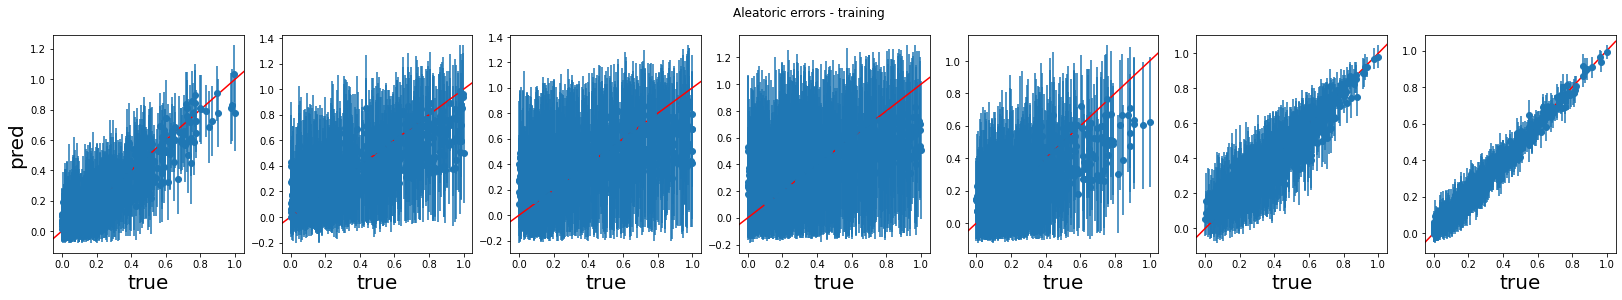

In [39]:
f, a = plt.subplots(1, Y_train.shape[1], figsize=(Y_train.shape[1]*4, 4))

plt.suptitle('Aleatoric errors - training')

for plot_id in range(Y_train.shape[1]):
    a[plot_id].errorbar(Y_train[:, plot_id], train_pred_ty_mean[:, plot_id], yerr = 2*train_pred_ty_aleatoric_interval[:, plot_id], fmt="o")
    a[plot_id].set_xlabel('true', fontsize=20)
    a[plot_id].axline([0, 0], [1, 1], color='r')

a[0].set_ylabel('pred', fontsize=20)

plt.savefig('plots/Aleatoric_training')
plt.show()

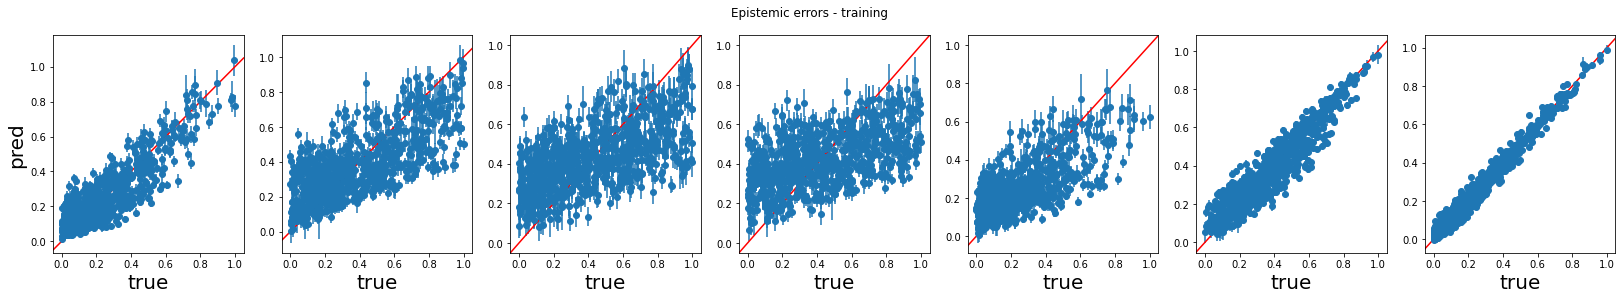

In [40]:
f, a = plt.subplots(1, Y_train.shape[1], figsize=(Y_train.shape[1]*4, 4))

plt.suptitle('Epistemic errors - training')


for plot_id in range(Y_train.shape[1]):
    a[plot_id].errorbar(Y_train[:, plot_id], train_pred_ty_mean[:, plot_id], yerr = 2*train_pred_ty_epistemic_interval[:, plot_id], fmt="o")
    a[plot_id].set_xlabel('true', fontsize=20)
    a[plot_id].axline([0, 0], [1, 1], color='r')

a[0].set_ylabel('pred', fontsize=20)

plt.savefig('plots/Epistemic_training')
plt.show()

In [41]:
pred_s_ty, pred_s_ty_aleatoric_var, pred_s_ty_epistemic_var = ensemble.predict_var_decomposition(X_test)

test_pred_ty_mean = pred_s_ty.loc.numpy() 
test_pred_ty_aleatoric_var = pred_s_ty_aleatoric_var 
test_pred_ty_epistemic_var = pred_s_ty_epistemic_var 

In [42]:
# 95.44% interval
test_pred_ty_aleatoric_interval = np.sqrt(test_pred_ty_aleatoric_var) 
test_pred_ty_epistemic_interval = np.sqrt(test_pred_ty_epistemic_var) 

In [43]:
aleatoric_ub = preprocessor_output.inverse_transform(test_pred_ty_mean+test_pred_ty_aleatoric_interval)
mid = preprocessor_output.inverse_transform(test_pred_ty_mean)
aleatoric_error = aleatoric_ub - mid

In [44]:
epistemic_ub = preprocessor_output.inverse_transform(test_pred_ty_mean+test_pred_ty_epistemic_interval)
epistemic_error = epistemic_ub - mid

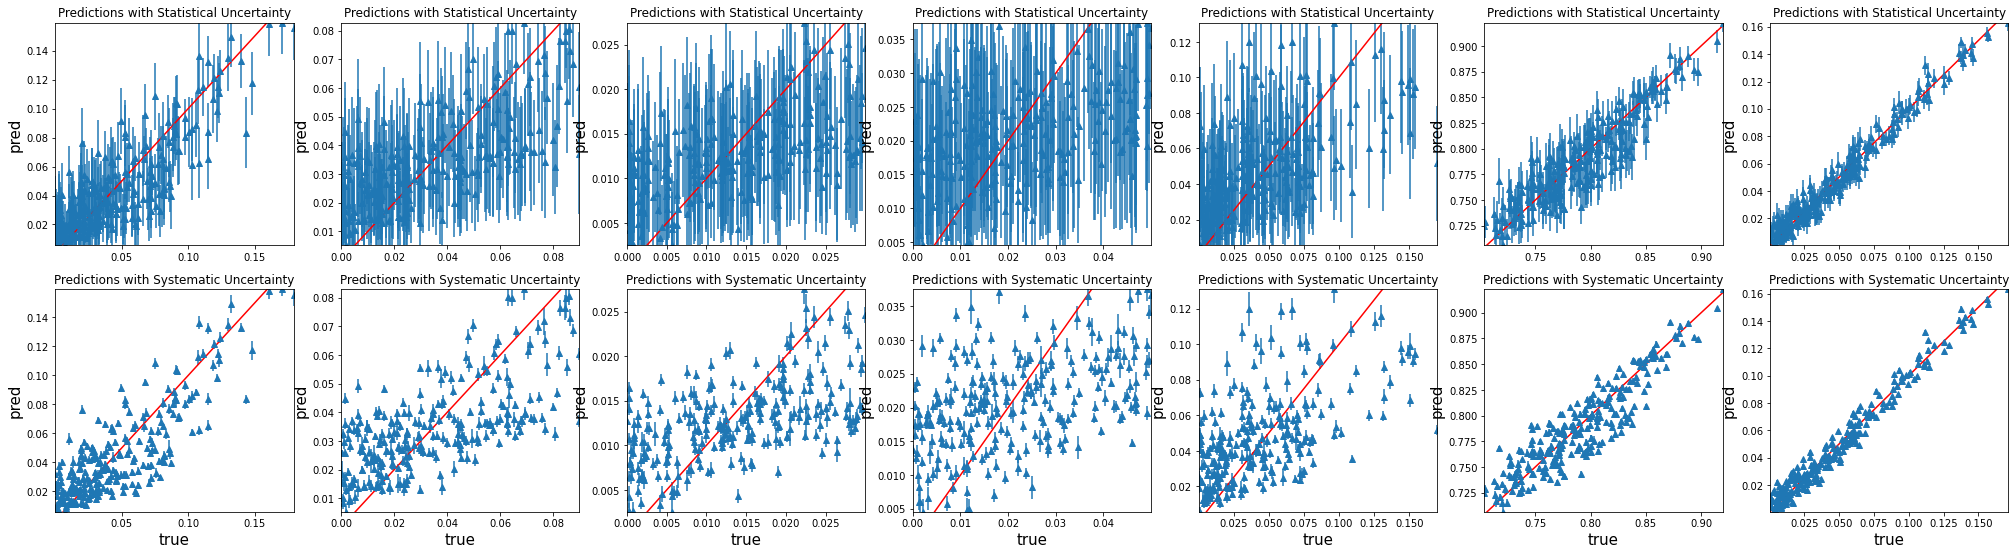

In [45]:
f, a = plt.subplots(2, Y_train.shape[1], figsize=(Y_train.shape[1]*5, 9))
allLabels = ['rx', 'ry', 'rz', 'dist', 'Smax', 'Vol75']

########

for plot_id in range(Y_train.shape[1]):

    a[0, plot_id].errorbar(preprocessor_output.inverse_transform(Y_test)[:, plot_id],
                 preprocessor_output.inverse_transform(test_pred_ty_mean)[:, plot_id],
                 aleatoric_error[:, plot_id],
                 linestyle='None', marker='^')
    a[0, plot_id].title.set_text('Predictions with Statistical Uncertainty')
    a[0, plot_id].set_ylabel('pred', fontsize=15)
    a[0, plot_id].axline([0, 0], [1, 1], color = 'r')
    a[0, plot_id].set_xlim(preprocessor_output.inverse_transform(Y_test)[:, plot_id].min(), preprocessor_output.inverse_transform(Y_test)[:, plot_id].max())
    a[0, plot_id].set_ylim(preprocessor_output.inverse_transform(test_pred_ty_mean)[:, plot_id].min(), preprocessor_output.inverse_transform(test_pred_ty_mean)[:, plot_id].max())


    ########


    a[1, plot_id].errorbar(preprocessor_output.inverse_transform(Y_test)[:, plot_id],
                 preprocessor_output.inverse_transform(test_pred_ty_mean)[:, plot_id], 
                 epistemic_error[:, plot_id],
                 linestyle='None', marker='^')
    a[1, plot_id].title.set_text('Predictions with Systematic Uncertainty')
    a[1, plot_id].set_xlabel('true', fontsize=15)
    a[1, plot_id].set_ylabel('pred', fontsize=15)
    a[1, plot_id].axline([0, 0], [1, 1], color = 'r')
    
    a[1, plot_id].set_xlim(preprocessor_output.inverse_transform(Y_test)[:, plot_id].min(), preprocessor_output.inverse_transform(Y_test)[:, plot_id].max())
    a[1, plot_id].set_ylim(preprocessor_output.inverse_transform(test_pred_ty_mean)[:, plot_id].min(), preprocessor_output.inverse_transform(test_pred_ty_mean)[:, plot_id].max())



plt.savefig('plots/uq_dh_test')
# plt.show()

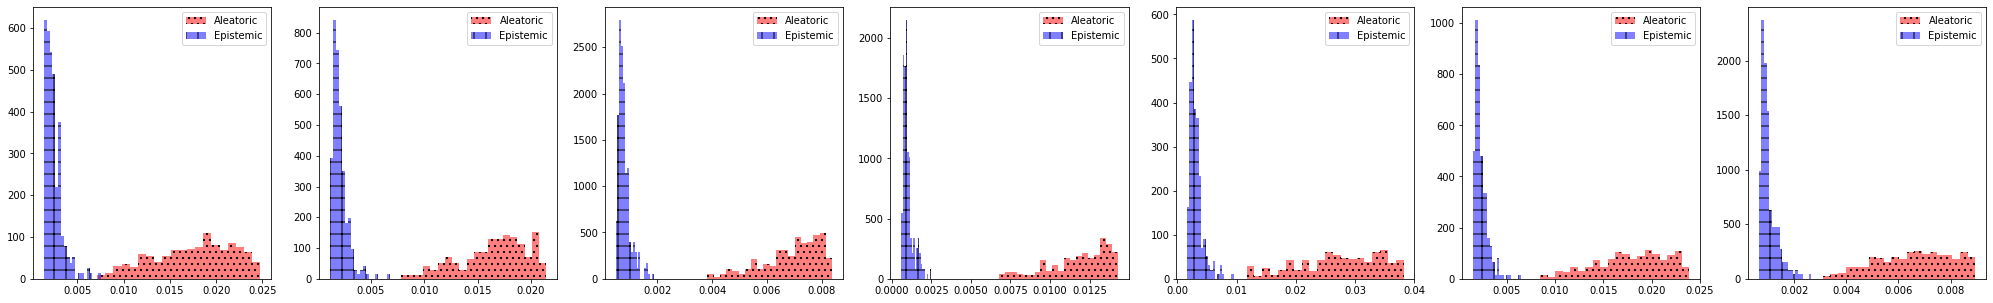

In [46]:
f, a = plt.subplots(1, Y_train.shape[1], figsize=(Y_train.shape[1]*5, 5))


for plot_id in range(Y_train.shape[1]):

    a[plot_id].hist(aleatoric_error[:, plot_id],bins=20, histtype='stepfilled', color='red', hatch='..', label='Aleatoric', alpha=0.5, density=True);
    a[plot_id].hist(epistemic_error[:, plot_id],bins=20, histtype='stepfilled', color='blue', hatch='+', label='Epistemic', alpha=0.5, density=True);
    a[plot_id].legend()

plt.savefig('plots/uq_hist')

In [47]:
# print input/output -- first few lines
# out text files similar to Sashi's requirements -- for individual out dimensions

In [48]:
testing_data_op = preprocessor_output.inverse_transform(Y_test)
testing_data_pred = preprocessor_output.inverse_transform(test_pred_ty_mean)

for op in range(Y_train.shape[1]):
    var_true = testing_data_op[:,op]
    var_pred = testing_data_pred[:,op]

    pdiff = abs((var_true - var_pred)*200/(var_true+var_pred))

    # np.savetxt('pdiff_var'+ str(op) + '.dat',pdiff,delimiter='  ',fmt='%12.5G')
    # np.savetxt('testvar_'+ str(op) + '.dat',testing_data_op[:,op],delimiter='  ',fmt='%12.5G')
    # np.savetxt('predvar_'+ str(op) + '.dat',testing_data_pred[:,op],delimiter='  ',fmt='%12.5G')

    dat = np.array([testing_data_op[:,op],testing_data_pred[:,op],pdiff])
    dat = dat.T
    np.savetxt('out/true_pred_diff_'+ str(op) + '.dat', dat ,delimiter='  ',fmt='%12.5G')

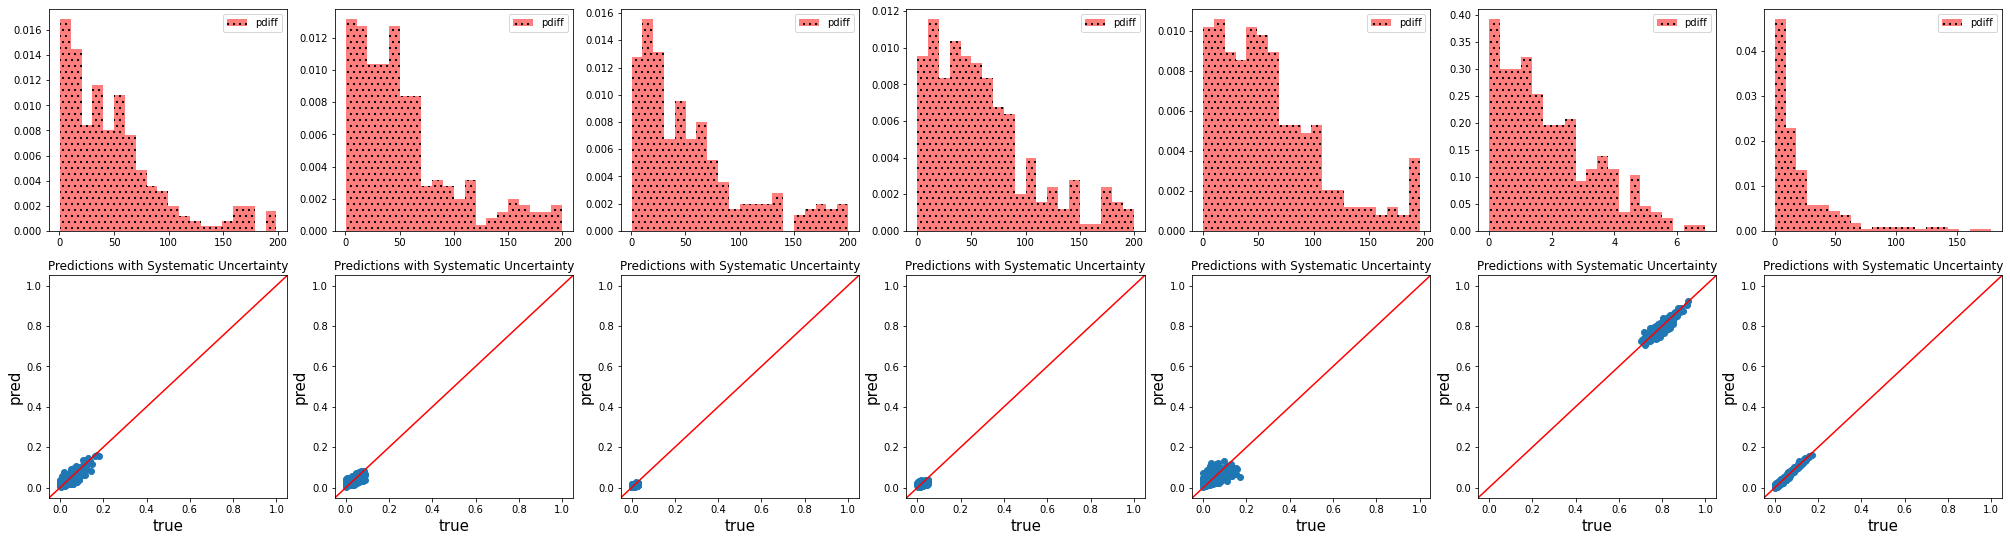

In [49]:
f, a = plt.subplots(2, Y_train.shape[1], figsize=(Y_train.shape[1]*5, 9))

for op in range(Y_train.shape[1]):
    load_dat = np.loadtxt('out/true_pred_diff_'+ str(op) + '.dat')
    a[0, op].hist(load_dat[:, 2], bins=20, histtype='stepfilled', color='red', hatch='..', label='pdiff', alpha=0.5, density=True);
    a[0, op].legend()
    
    
    a[1, op].scatter(load_dat[:, 0],
                  load_dat[:, 1])
    a[1, op].title.set_text('Predictions with Systematic Uncertainty')
    a[1, op].set_xlabel('true', fontsize=15)
    a[1, op].set_ylabel('pred', fontsize=15)
    a[1, op].axline([0, 0], [1, 1], color = 'r')
    
    

plt.savefig('plots/pdiff_hist')